In [1]:
using Images

Download the test images:

In [2]:
run(`wget http://cs.brown.edu/courses/cs019/2014/Assignments/Fluid-Images/belur-carving-s2.jpg`)
run(`wget http://cs.brown.edu/courses/cs019/2014/Assignments/Fluid-Images/bangalore-dancers-s2.jpg`)
run(`wget http://cs.brown.edu/courses/cs019/2014/Assignments/Fluid-Images/british-museum-s2.jpg`)

--2014-12-06 14:22:22--  http://cs.brown.edu/courses/cs019/2014/Assignments/Fluid-Images/belur-carving-s2.jpg
Resolving cs.brown.edu (cs.brown.edu)... 128.148.32.12
Connecting to cs.brown.edu (cs.brown.edu)|128.148.32.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11428 (11K) [image/jpeg]
Saving to: ‘belur-carving-s2.jpg.5’

     0K .......... .                                          100%  167K=0.07s

2014-12-06 14:22:29 (167 KB/s) - ‘belur-carving-s2.jpg.5’ saved [11428/11428]

--2014-12-06 14:22:29--  http://cs.brown.edu/courses/cs019/2014/Assignments/Fluid-Images/bangalore-dancers-s2.jpg
Resolving cs.brown.edu (cs.brown.edu)... 128.148.32.12
Connecting to cs.brown.edu (cs.brown.edu)|128.148.32.12|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13252 (13K) [image/jpeg]
Saving to: ‘bangalore-dancers-s2.jpg.3’

     0K .......... ..                                         100% 24.0K=0.5s

2014-12-06 14:22:31 (24.0 KB/s) - ‘bangalo

What do they contain?

Options{:ToggleButtons,ASCIIString}([Input{ASCIIString}] belur-carving-s2.jpg,"file","belur-carving-s2.jpg","belur-carving-s2.jpg",["belur-carving-s2.jpg"=>"belur-carving-s2.jpg","bangalore-dancers-s2.jpg"=>"bangalore-dancers-s2.jpg","british-museum-s2.jpg"=>"british-museum-s2.jpg"])

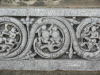

In [3]:
using Interact

filenames = ["belur-carving-s2.jpg", "bangalore-dancers-s2.jpg", "british-museum-s2.jpg"]
@manipulate for file in filenames
    imread(file)
end

In [4]:
size(imread("belur-carving-s2.jpg")) # small enough?

(100,75)

Code for calculating pixel properties

In [5]:
brightness(color) = color.r + color.g + color.b

function getvalue(img, i, j)
    w, h = size(img)
    if i < 1 || j < 1 || i > w || j > h
        return 0.0f0
    end
    return brightness(img[i, j])
end

function energy(img, i, j)
    # A B C
    # D E F
    # G H I
    w, h = size(img)
    a, d, g, b, e, h, c, f, i = [getvalue(img, x, y) for x=i-1:i+1, y=j-1:j+1]
    xenergy=a + 2d + g - c - 2f - i
    yenergy=a + 2b + c - g - 2h - i
    √((xenergy^2) + (yenergy^2))
end

energy (generic function with 1 method)

A type for representing a map of min-seam direction

In [6]:
immutable Next
    direction::Int8
    energy::Float32
end # Next takes 8+32=40 contigious bytes

`markminpaths` marks the seams from a given x, y coordinate

In [7]:
function mapseams!(img, mem, x, y=1)
    # virtical seam starting with (x, y)

    w, h = size(img)
    if x > w || x < 1
        return Next(3, Inf)
    end
    if y > h || y < 1
        return Next(3, 0.0f0)
    end
    if mem[x, y].direction != 2
        return mem[x, y]
    end

    next = mapseams!(img, mem, x-1, y+1)
    E = next.energy
    next_dir = -1
    for i in [x, x+1] # two more paths to explore
        tmp = mapseams!(img, mem, i, y+1)
        if tmp.energy < E
            E = tmp.energy
            next_dir = i-x
        end
    end
    res = Next(next_dir, E + energy(img, x, y))
    mem[x, y] = res
    return res
end

function mapseams(img)
    w, h = size(img)
    m = fill(Next(2, 0.0f0), (w, h))
    for i=1:w
        mapseams!(img, m, i, 1) # mark all min-seams
    end
    m
end

mapseams (generic function with 1 method)

given a matrix of Next values, figure out a seam starting at (x, 1)

In [8]:
function get_seam(seammap, x)
    w, h = size(seammap)

    path = Array(Int, h)
    for y = 1:h
        path[y] = x
        x += seammap[x, y].direction
    end
    path
end

get_seam (generic function with 1 method)

In [9]:
using Color

# For inspection, mark a seam

function markseam(img, seam, color=RGB(1,0,0))
    img′ = copy(img)
    w, h = size(img)
    for j=1:length(seam)
        img′[seam[j], j]=color
    end
    img′
end

markseam (generic function with 2 methods)

Slider{Int64}([Input{Int64}] 50,"i",50,1:100)

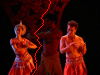

In [10]:
test_img = imread("bangalore-dancers-s2.jpg")
@manipulate for i=1:width(test_img)
    markseam(test_img, get_seam(mapseams(test_img), i))
end

In [11]:
# get the min-seam
function minseam(seammap)
    _, idx = findmin([pos.energy for pos in seammap[:, 1]])
    get_seam(seammap, idx)
end

minseam (generic function with 1 method)

In [14]:
function carve(img, seam) # Carve out a seam
    w, h = size(img)
    img′ = fill(RGB(0.0f0, 0.0f0, 0.0f0), w-1, h)

    for y=1:h
        i=1
        for x=1:w
            if seam[y] == x
            else
                img′[i, y] = img[x, y]
                i += 1
            end
        end
    end
    Image(img′, ["spatialorder" => ["x", "y"]]) # same spatial ordering as the original
end

carve (generic function with 1 method)

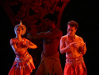

In [15]:
img1 = carve(test_img, minseam(mapseams(test_img)))

In [16]:
size(img1)

(99,75)

Woot! That seems to have worked. But does it really? How does it look while it's at it?

In [17]:
# IJulia's image widget assumes width does not change, so we will
# define a type and our own way of showing the image.
immutable ImgFrame
    img::Image
end

Base.writemime(io::IO, m::MIME"text/html", frame::ImgFrame) = 
write(io, """<img src="data:image/png;base64,$(stringmime(MIME("image/png"), frame.img))"/>""")

writemime (generic function with 27 methods)

Slider{Int64}([Input{Int64}] 49,"n",49,0:99)

Checkbox([Input{Bool}] true,"show_next",true)

Options{:ToggleButtons,ASCIIString}([Input{ASCIIString}] belur-carving-s2.jpg,"file","belur-carving-s2.jpg","belur-carving-s2.jpg",["belur-carving-s2.jpg"=>"belur-carving-s2.jpg","bangalore-dancers-s2.jpg"=>"bangalore-dancers-s2.jpg","british-museum-s2.jpg"=>"british-museum-s2.jpg"])

ImgFrame(RGB Image with:
  data: 51x75 Array{RGB{Float32},2}
  properties:
    spatialorder:  x y)
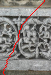

In [21]:
@manipulate for n=0:99, show_next=true, file in filenames
    img = imread(file)
    for i=1:n
        img = carve(img, minseam(mapseams(img)))
    end
    ImgFrame(show_next ? markseam(img, minseam(mapseams(img))) : img)
end